# Neural & Behavioral Modeling - Week 5 (Examples)
by Tsung-Ren (Tren) Huang (tren.huang@gmail.com)

In [235]:
%config IPCompleter.greedy=True 
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from IPython.display import *

## 1 Parameter Estimation
This is mainly for WHAT models.

### 1.0 Simulated data
To test a new method/algorithm, we often genrate ground-truth data by ourselves instead of using real data.

Here is the way to generate a series of $(x_i,y_i)$ such that the Pearson's correaltion $r(X,Y)=\rho$:

$X=N(\mu_1,\sigma_1)$

$Y=\sqrt{1-\rho^2}*N(\mu_2,\sigma_2)+\rho*X$

In [236]:
from scipy.stats import *

Ndata=10000 # number of data points
rho=.8 # desired correlation
x=random.normal(0,1,Ndata) # mu=0, sigma=1
print(mean(x),std(x))
y=sqrt(1-rho**2)*random.normal(0,1,Ndata)+rho*x+2 # mu=2, sigma=1
print(mean(y),std(y))
print(pearsonr(x,y)) # showing (r,p)

-0.00949617745282 1.00214965766
1.99181327979 0.999749369545
(0.79934648386225915, 0.0)


### 1.1a Analytically Solving Linear Equations
A linear regression function $y_i=b_0+b_1X_i+e_i$ can be rewritten in matrix form:

$Y=XB+e$

and the unknow coefficient can be computed from the two known vectors/matrices X & Y:

$B=(X^TX)^{-1}X^TY$.

In [237]:
# Ground-truth regression line: Y=0.8*X+2
X=hstack([ones([Ndata,1]),array([x]).T])
print('X=',X)
Y=array([y]).T
print('Y=',Y)
B=matmul(matmul(linalg.inv(matmul(X.T,X)),X.T),Y)
print('B=',B) # showing [intercept, r(X,Y)]

X= [[ 1.         -1.86329347]
 [ 1.         -0.61803084]
 [ 1.          0.05579907]
 ..., 
 [ 1.          0.5850662 ]
 [ 1.         -0.36042751]
 [ 1.         -0.20964878]]
Y= [[ 1.80896394]
 [ 1.14010125]
 [ 3.30026937]
 ..., 
 [ 4.11742166]
 [ 0.8689329 ]
 [ 0.84762975]]
B= [[ 1.99938583]
 [ 0.79743194]]


### 1.1b Numerically Solving Linear Equations

Solving $Y=XB$ can be recast into an optimization problem:
    
Find $\hat{B}$ to minimize $|\hat{Y}-Y|=|X\hat{B}-Y|$.

There are then tons of algorithms to use, including grid search, gradient descent, Simplex, simulated annealing, genetic algorithms, etc.

Here we demonstrate the use of grid search & gradient descent because they are most relevant to machine learning and neural networks.

In [239]:
# Ground-truth regression line: y=b1*x+b0=0.8*x+2 

# (1) Grid search: finding [b0, b1] with brute force
min_diff=inf # min difference between model-predicted y & real/observed y
best_b0,best_b1=inf,inf
for b0 in arange(-10,10,0.1):
    for b1 in arange(-10,10,0.1):
        B=array([[b0,b1]]).T
        Y_pred=matmul(X,B)
        dist=linalg.norm(Y_pred-Y)
        if(dist<min_diff):
            min_diff=dist
            best_b0=b0
            best_b1=b1
print(best_b0,best_b1,min_diff)

2.0 0.8 60.0725573568


In [241]:
# Ground-truth regression line: y=b1*x+b0=0.8*x+2 

# (2) Gradient descent: finding [b0, b1] along the gradient direction
# Supporting function:

def f(X,Y,B): # distance function: f(X,Y,B)=|XB-Y|
    Y_pred=matmul(X,B)
    return(linalg.norm(Y_pred-Y))

def dB(f,X,Y,B): # Numerical gradient df(X,Y,B)/dB @ B
    h=1e-4 # 0.0001
    g=np.zeros_like(B)
    for i in range(B.size): # partial differentiation along a particular dimension
        tmp=B[i]
        B[i]=float(tmp)+h        
        f1=f(X,Y,B) # f(B+h)
        B[i]=float(tmp)-h
        f2=f(X,Y,B) # f(B-h)
        g[i]=(f1-f2)/(2*h)
        B[i]=tmp # revert to the original
    return g

# Iterative optimization:

B=array([[0.,0.]]).T # initial values
step=0.01
old_dist,new_dist=inf,0
while(abs(old_dist-new_dist)>0.1): # if not converged yet
    old_dist=f(X,Y,B)
    B-=step*dB(f,X,Y,B) # gradient descent
    new_dist=f(X,Y,B)
    
print(B[0,0],B[1,0],new_dist)

1.99619855376 0.795872416006 60.0730181299


### 1.2 Numerically Solving Nonlinear Equations
Note that the numerical methods in 1.1b can be applied to solve all kinds of nonlinear equations, which are implemented as functions in [scipy.optimization](https://docs.scipy.org/doc/scipy/reference/optimize.html).

Optimization terminated successfully.
         Current function value: 0.000055
         Iterations: 72
         Function evaluations: 137
B from fmin [ 1.00000171 -3.00003497]
B from curve_fit [ 1. -3.]


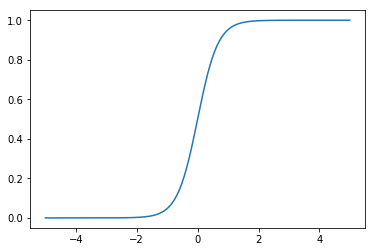

In [169]:
from scipy.optimize import *

# Ground-truth function: y=b0/(1+exp(b1*x))=1/(1+exp(-3*x))
X=arange(-5,5,0.01)
Y=1/(1+exp(-3*X))
plot(X,Y)

# (1) Data-fitting using the simplex algorithm: fmin
B0=array([[0.,0.]]).T # initial values
f1=lambda X,Y,B: linalg.norm(Y-B[0]/(1+exp(B[1]*X)))
f2=lambda B: f1(X,Y,B)
B=fmin(f2, B0)
print('B from fmin',B)

# (2) Data-fitting using the least squares method:
f3 = lambda X,b0,b1: b0/(1+exp(b1*X))
[B,cov]=curve_fit(f3,X,Y) 
print('B from curve_fit',B)

## 2 Modeling Reaction Time

### 2.1 WHAT model: [Ex-Gaussian](https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution)
= one [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) + one [Guassian distribution](https://en.wikipedia.org/wiki/Normal_distribution)

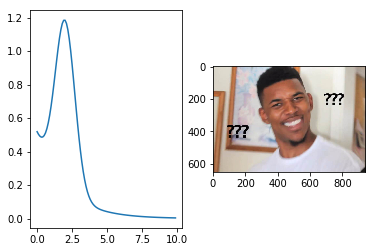

In [243]:
from skimage import io

# Model parameters:
mu,sigma=2,1
lmbd=0.5

x=arange(0,10,0.1)
exGauss=lmbd*exp(-lmbd*x)+exp(-((x-mu)/sigma)**2)
subplot(1,2,1);plot(x,exGauss)
subplot(1,2,2);imshow(io.imread("http://goo.gl/Jcqbnt"));

The PDF of exGaussian is actually <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/f01b07f828435157d666a08bf168dffe9993a2f4'>

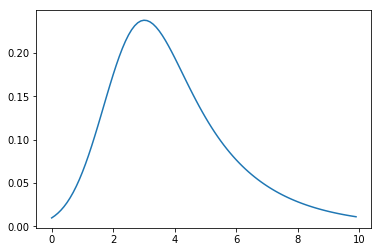

In [226]:
from scipy.special import erfc
exGauss=lmbd/2*exp(lmbd/2*(2*mu+lmbd*sigma**2-2*x))*erfc((mu+lmbd*sigma**2-x)/(sqrt(2)*sigma))
plot(x,exGauss);

### 2.2 HOW model: Diffusion

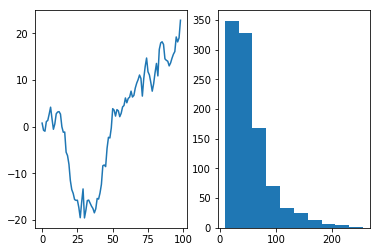

In [246]:
from numpy import *

mu,sigma=0.2,2 # Diffusion type1
p=0.4 # Diffusion type2
Yend=20 # Threshold for response
Ntrial=1000

RTs=zeros(Ntrial)
for i in range(Ntrial):
    Y=0 # initial drift position
    Ys=[] # drift history
    RT=0 # Reset watch
    while(Y<Yend):
        dY=mu+random.normal(mu,sigma); # type1
        #dY=float((random.rand(1)-p)>0); # type2
        Y=Y+dY
        Ys.append(Y); # Diffusion history in each trial
        RT=RT+1 # clock is running
    RTs[i]=RT;
subplot(1,2,1);plot(Ys) # plot only the last trial to see the diffusion process
subplot(1,2,2);hist(RTs);

## 3 Modeling Accuracy

### 3.1 Exemplar model vs. Prototype model

#### 3.1a Linearly separable problem (Matlab program not ported to Python yet)

In [ ]:
function ExemProto1()

%PARAMETERS
           D = 2;   % # of stimulus dimensions
        Cats = 2;   % # of categories
   N_Exemps = 20;   % # exemplars per category in training
     Trials = 10;   % # of test (generalization) trials
      Sigma = 1.0;  % SD of sampling distribution around each dimension
     Lambda = 0.5;  % Sensitivity parameter to Shepard similarity scaling

%DATA STRUCTURES
   Cat_Center = zeros(Cats,D); 
       Memory = zeros(Cats, N_Exemps, D); 
    Prototype = zeros(Cats, D); 
         Stim = zeros(1,D);
   
%=========================================================================
%BEGIN SIMULATION

%Assigning Category Centers:
Cat_Center(1,1) = 1; 
Cat_Center(1,2) = 10; 
Cat_Center(2,1) = 10;
Cat_Center(2,2) = 1; 

%Generating exemplars to put into memory
for i = 1:Cats
    for j = 1:N_Exemps
      Stim(1) = Cat_Center(i,1) + randn*Sigma;
      Stim(2) = Cat_Center(i,2) + randn*Sigma;
      Memory(i,j,:) = Stim;
      Prototype(i,:) = Prototype(i,:) + Stim;
    end
end
Prototype = Prototype / N_Exemps; 


% Classifying novel exemplars: 
Accuracy = zeros(2,Trials);   % Response accuracy under each model

for i = 1:Trials
   targ_type = round(rand+1);  % flip a coin
   Stim(1) = Cat_Center(targ_type,1) + randn*Sigma; 
   Stim(2) = Cat_Center(targ_type,2) + randn*Sigma; 
   Accuracy(1,i) = Prototype_Response(Prototype, Stim, targ_type); 
   Accuracy(2,i) = Exemplar_Response(Memory, Stim, targ_type); 
end

% Showing Category Structure on screen: 
clf;
scatter(Memory(1,:,1), Memory(1,:,2), 'filled')
hold on;
scatter(Memory(2,:,1), Memory(2,:,2), 'filled')
hold on; 
scatter(Prototype(:,1), Prototype(:,2), 120)
fprintf('\n')
fprintf('%s%6.4f\n', 'Prototype Accuracy: ', sum(Accuracy(1,:))/Trials); 
fprintf('%s%6.4f\n', 'Exemplar Accuracy: ', sum(Accuracy(2,:))/Trials); 

% END SIMULATION  
%=========================================================================


%======================================================================
%   TOOLS FOLLOW:
%======================================================================


%***********************************************************************
function [Scalar] = Prototype_Response(Prototype, Stim, targ_type)
      d = zeros(1, Cats); 
    sim = zeros(1, Cats); 
      
    for x = 1:Cats
      for y = 1:D
         d(x)= d(x) + (Stim(y) - Prototype(x,y))^2; % Stimulus distance
      end
    end
          
    sim = exp(-Lambda*d);                           % Psychological distance 
    prob = sim(targ_type) / (sum(sim));             % Luce Choice rule   
    Scalar = prob; 
    
end
%***********************************************************************    
    
%***********************************************************************
function [Scalar] = Exemplar_Response(Memory, Stim, targ_type)
      d = zeros(Cats, N_Exemps); 
    sim = zeros(Cats, N_Exemps); 
      
    for x = 1:Cats
      for y = 1:N_Exemps                                % Note that this is NOT optimal
        for z = 1:D
          d(x,y)= d(x,y) + (Stim(z) - Memory(x,y,z))^2; % Stimulus distance
        end
      end
    end
             
    sim = exp(-Lambda*d);                               % Psychological distance
    prob = sum(sim(targ_type,:)) / (sum(sum(sim)));     % Luce Choice rule  
    Scalar = prob;

end
%***********************************************************************    
    
    

end %ExemProto1.m

#### 3.2b XOR problem (Matlab program not ported to Python yet)

In [ ]:
function ExemProto2()

%PARAMETERS
          D = 2;   % # of stimulus dimensions
       Cats = 2;   % # of categories
   N_Exemps = 20;   % # exemplars per category in training
     Trials = 10;   % # of test (generalization) trials
      Sigma = 1.0;  % SD of sampling distribution around each dimension
     Lambda = 0.5;  % Sensitivity parameter to Shepard similarity scaling

%DATA STRUCTURES
   Cat_Center = zeros(Cats,2,D); 
       Memory = zeros(Cats, N_Exemps*2, D); 
    Prototype = zeros(Cats, D); 
         Stim = zeros(1,D);
   
%=========================================================================
%BEGIN SIMULATION

%Assigning Category Centers:
Cat_Center(1,1,1) = 1; 
Cat_Center(1,1,2) = 10; 
Cat_Center(1,2,1) = 10;
Cat_Center(1,2,2) = 1;
Cat_Center(2,1,1) = 1;
Cat_Center(2,1,2) = 1; 
Cat_Center(2,1,1) = 10;
Cat_Center(2,1,2) = 10; 

%Generating exemplars to put into memory

for i = 1:Cats
    count = 0; 
    for j = 1:N_Exemps
      for k = 1:2
       count = count + 1; 
       Stim(1) = Cat_Center(i,k,1) + randn*Sigma;
       Stim(2) = Cat_Center(i,k,2) + randn*Sigma;
       Memory(i,count,:) = Stim;
       Prototype(i,:) = Prototype(i,:) + Stim;
      end
    end
end
Prototype = Prototype / (N_Exemps*2); 


% Classifying novel exemplars: 
Accuracy = zeros(2,Trials);   % Response accuracy under each model

for i = 1:Trials
   targ_type = round(rand+1);  % flip a coin
   Stim(1) = Cat_Center(targ_type,1,1) + randn*Sigma; 
   Stim(2) = Cat_Center(targ_type,1,2) + randn*Sigma; 
   Accuracy(1,i) = Prototype_Response(Prototype, Stim, targ_type); 
   Accuracy(2,i) = Exemplar_Response(Memory, Stim, targ_type); 
end


% Showing Category Structure on screen: 
clf;
scatter(Memory(1,:,1), Memory(1,:,2), 'filled')
hold on;
scatter(Memory(2,:,1), Memory(2,:,2), 'filled')
hold on; 
scatter(Prototype(:,1), Prototype(:,2), 120)
fprintf('\n')
fprintf('%s%6.4f\n', 'Prototype Accuracy: ', sum(Accuracy(1,:))/Trials); 
fprintf('%s%6.4f\n', 'Exemplar Accuracy: ', sum(Accuracy(2,:))/Trials); 

% END SIMULATION  
%=========================================================================


%======================================================================
%   TOOLS FOLLOW:
%======================================================================


%***********************************************************************
function [Scalar] = Prototype_Response(Prototype, Stim, targ_type)
      d = zeros(1, Cats); 
    sim = zeros(1, Cats); 
      
    for x = 1:Cats
      for y = 1:D
         d(x)= d(x) + (Stim(y) - Prototype(x,y))^2; % Stimulus distance
      end
    end
          
    sim = exp(-Lambda*d);                           % Psychological distance 
    prob = sim(targ_type) / (sum(sim));             % Luce Choice rule   
    Scalar = prob; 
    
end
%***********************************************************************    
    
%***********************************************************************
function [Scalar] = Exemplar_Response(Memory, Stim, targ_type)
      d = zeros(Cats, N_Exemps); 
    sim = zeros(Cats, N_Exemps); 
      
    for x = 1:Cats
      for y = 1:N_Exemps                                % Note that this is NOT optimal
        for z = 1:D
          d(x,y)= d(x,y) + (Stim(z) - Memory(x,y,z))^2; % Stimulus distance
        end
      end
    end
             
    sim = exp(-Lambda*d);                               % Psychological distance
    prob = sum(sim(targ_type,:)) / (sum(sum(sim)));     % Luce Choice rule  
    Scalar = prob;

end
%***********************************************************************    
    

end %ExemProto2.m